In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Change to statsmodels.tsa.arima.model on jupyter notebook
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet

import warnings
warnings.simplefilter('ignore')

plt.style.use("fivethirtyeight")

In [80]:
# for working on google colab 
# from google.colab import files
# uploaded = files.upload()

Saving index_funds_data.csv to index_funds_data (2).csv


In [81]:
funds = pd.read_csv('../data/index_funds_data.csv')
funds['date'] = pd.to_datetime(funds['date'],infer_datetime_format=True)
funds = funds[['symbol','date','close']]
funds = funds.set_index(['symbol','date'])
NASDX = funds.loc['NASDX',['close']]

### Visualize The Closing Price

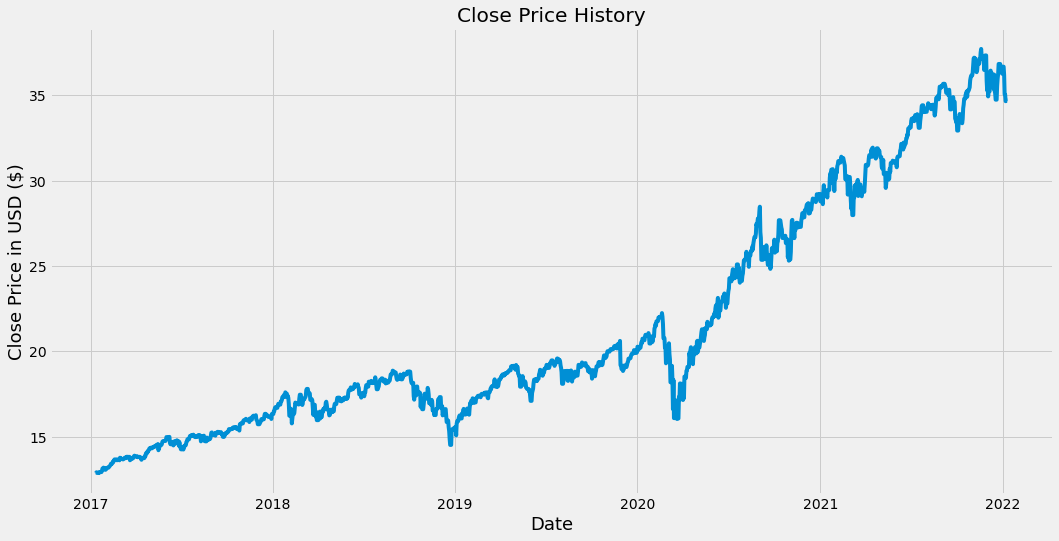

In [82]:
plt.figure(figsize=(16,8))
plt.plot(NASDX['close'])
plt.title("Close Price History")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price in USD ($)",fontsize=18)
plt.show()

### Baseline "Naive" Model

In [83]:
NASDX_baseline = NASDX.shift(60)
NASDX_base_rmse = mean_squared_error(NASDX[60:],NASDX_baseline[60:],squared=False)
NASDX_base_rmse

1.6403598893450908

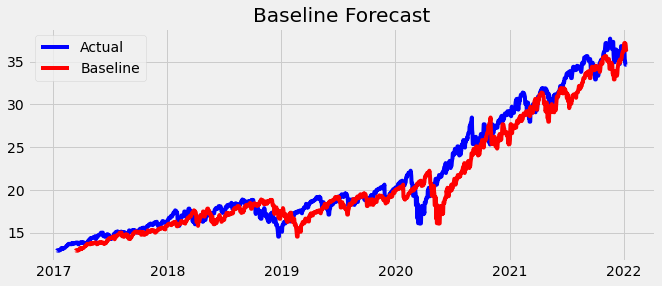

In [84]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Baseline Forecast")
ax.plot(NASDX,c='b',label='Actual')
ax.plot(NASDX_baseline,c='r',label='Baseline')
plt.legend()
plt.show()

In [85]:
new_df = pd.DataFrame()
new_df['original'] = NASDX['close']
new_df['shifted'] = NASDX['close'].shift(60)
cutoff = int(len(new_df['original']) * 0.80)
original = new_df['original']
shifted = new_df['shifted']
original_train, original_test = original[60:cutoff], original[cutoff:]
shifted_train, shifted_test = shifted[60:cutoff], shifted[cutoff:]

In [86]:
baseline_rmse = mean_squared_error(original_train,shifted_train,squared=False)
baseline_rmse

1.5885899183148018

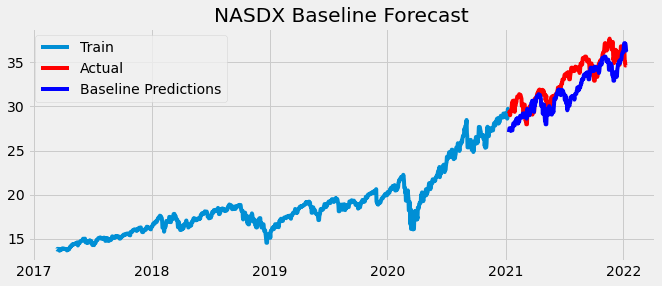

In [87]:
plt.figure(figsize=(10,4))
plt.title('NASDX Baseline Forecast')
plt.plot(original_train,label='Train')
plt.plot(original_test,c='r',label='Actual')
plt.plot(shifted_test,c='blue',label='Baseline Predictions')
plt.legend()
plt.show()

In [88]:
def get_combos(n,k):
    p = d = q = range(n, k)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    return pdqs

def get_optimal_params(ts,n,k):
    pdq = get_combos(n,k)
    ans = []
    for comb in pdq:
        try:
            model = ARIMA(ts,
                         order=comb)
            output = model.fit()
            ans.append([comb,output.aic])
        except:
            continue
    ans_df = pd.DataFrame(ans, columns=['pdq','aic'])
    optimals = ans_df.loc[ans_df['aic'].idxmin()]
    return optimals

def arima_models(ts,n,k):
    order = get_optimal_params(ts,n,k)['pdq']
    model = ARIMA(ts,
                 order=order)
    output = model.fit()
    return output

def train_test_splt(ts,test_size):
    cutoff = int(ts.shape[0]*(1-test_size))
    train = ts[:cutoff]
    test = ts[cutoff:]
    return train, test

def find_rmse(model, test_data):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return y_hat, np.sqrt(mean_squared_error(test_data, y_hat))

NASDX_train, NASDX_test = train_test_splt(NASDX,.2)

In [89]:
# Find optimal pdq
print(get_optimal_params(NASDX_train,0,3))

# Fit ARIMA with optimal pdq
arima_model = arima_models(NASDX_train,0,3)

# Summary of model
arima_model.summary()

pdq    (1, 1, 1)
aic     -43.0801
Name: 10, dtype: object


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1459
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  25.540
Method:                       css-mle   S.D. of innovations              0.238
Date:                Thu, 20 Jan 2022   AIC                            -43.080
Time:                        03:25:52   BIC                            -21.938
Sample:                    01-13-2017   HQIC                           -35.193
                         - 01-10-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0112      0.006      1.976      0.048    8.89e-05       0.022
ar.L1.D.close    -0.4887      0.121     -4.022      0.000      -0.727      -0.251
ma.L1.D.close     0.3564      0.129      2.753      0.006       0.103       0.610
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0463           +0.0000j            2.0463            0.5000
MA.1           -2.8055           +0.0000j            2.8055            0.5000
-----------------------------------------------------------------------------
"""

In [90]:
# arima_model.plot_diagnostics(figsize=(12,8))
# plt.tight_layout();

In [91]:
yhat ,arima_rmse = find_rmse(arima_model,NASDX_test)

In [92]:
arima_rmse

2.2927055377118286

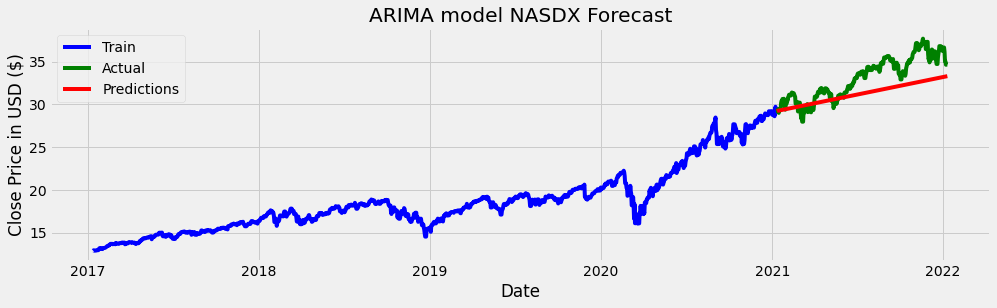

In [93]:
plt.figure(figsize=(15,4))
plt.title('ARIMA model NASDX Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price in USD ($)')
plt.plot(NASDX_train,c="blue",label='Train')
plt.plot(NASDX_test,c='green',label='Actual')
plt.plot(yhat, c='red',label='Predictions')
plt.legend()
plt.show()

### LSTM Model

In [94]:
data = NASDX.filter(['close'])
dataset = data.values
cutoff = int(len(dataset)*0.8)
cutoff

1460

In [95]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00000000e+00],
       [2.01288245e-03],
       [4.02576490e-04],
       ...,
       [8.78824477e-01],
       [8.78824477e-01],
       [8.78824477e-01]])

In [96]:
# create scaled training set
train_data = scaled_data[0:cutoff,:]
X_train = []
y_train = []

for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [97]:
# convert X_train and y_train to numpy arrays for training the model
X_train, y_train = np.array(X_train), np.array(y_train)

In [98]:
# reshape X_train for LSTM model
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1400, 60)
(1400, 60, 1)


In [99]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [100]:
# compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [101]:
# train the model
model.fit(X_train, y_train, batch_size=1,epochs=1)

1400/1400 [==============================] - 43s 28ms/step - loss: 8.3968e-04


In [102]:
# creating test data
test_data = scaled_data[cutoff-60:,:]
X_test = []
y_test = dataset[cutoff:,:]

for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [103]:
# convert X_test to numpy array
X_test = np.array(X_test)

In [104]:
# reshape X_test for LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [105]:
# get model preds
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [106]:
# get rmse
lstm_rmse = mean_squared_error(y_test,predictions,squared=False)
lstm_rmse

0.5621825967364662

In [107]:
# plot the data
train = data[:cutoff]
actual = data[cutoff:]

actual['Predictions'] = predictions

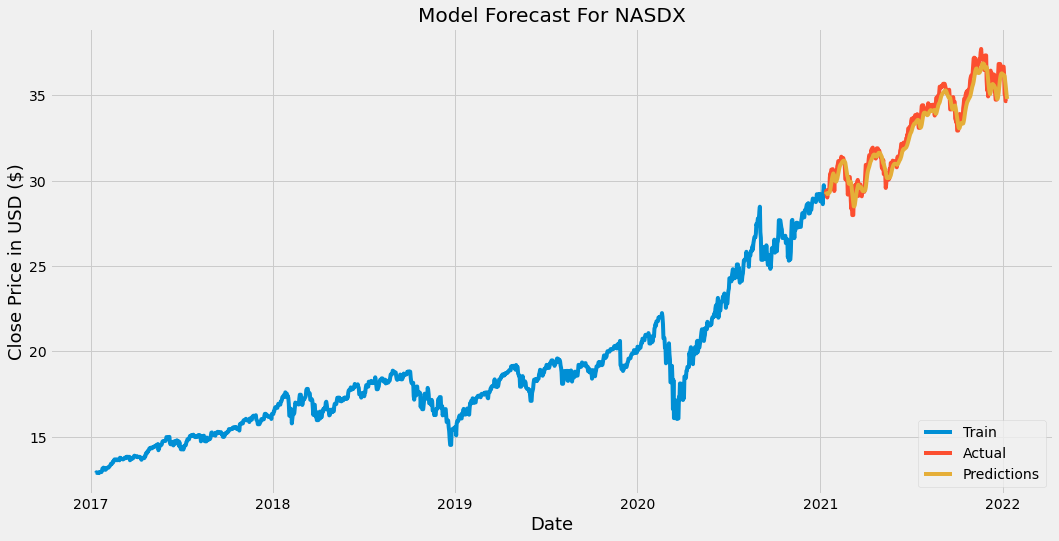

In [108]:
# visualize 
plt.figure(figsize=(16,8))
plt.title("Model Forecast For NASDX")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price in USD ($)",fontsize=18)
plt.plot(train['close'])
plt.plot(actual['close'])
plt.plot(actual['Predictions'])
plt.legend(['Train','Actual','Predictions'],loc='lower right')
plt.show()

### FBprophet Model

In [109]:
# Helper functions

def prep_dataframe(df):
    ts = df.copy()
    ts.rename(columns={'close':'y'},inplace=True)
    ts.index.name = 'ds'
    ts = ts.reset_index()
    ts['ds'] = ts['ds'].apply(lambda x: x.replace(tzinfo=None))
    return ts

def fit_train(data,prepared=True):
    # Format dataframe to fbprophet requirements in not already done
    if prepared == False:
        data = prep_dataframe(data)

    # Train-Test Split
    cutoff = int(data.shape[0] * 0.80)
    train = data.iloc[:cutoff]
    test = data.iloc[cutoff:]

    # Fit the model
    mod = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
    fitted_mod = mod.fit(train)

    if prepared == False:
        return fitted_mod, data, train, test
    else:
        return fitted_mod, train, test

def get_preds(model,test_data):
    preds = model.predict(test_data[['ds']])
    return preds[['ds','yhat_lower','yhat_upper','yhat']]

def get_rmse(preds, test_data):
    return mean_squared_error(preds['yhat'],test_data['y'],squared=False)

In [110]:
mod, NASDX_prepped, train, test = fit_train(NASDX,False)

In [111]:
predictions = get_preds(mod,test)

In [112]:
fbprophet_rmse = get_rmse(predictions,test)

In [113]:
fbprophet_rmse

5.670109251774348

In [114]:
train = train.set_index('ds')
test = test.set_index('ds')

In [115]:
predictions = predictions[['ds','yhat']].set_index('ds')

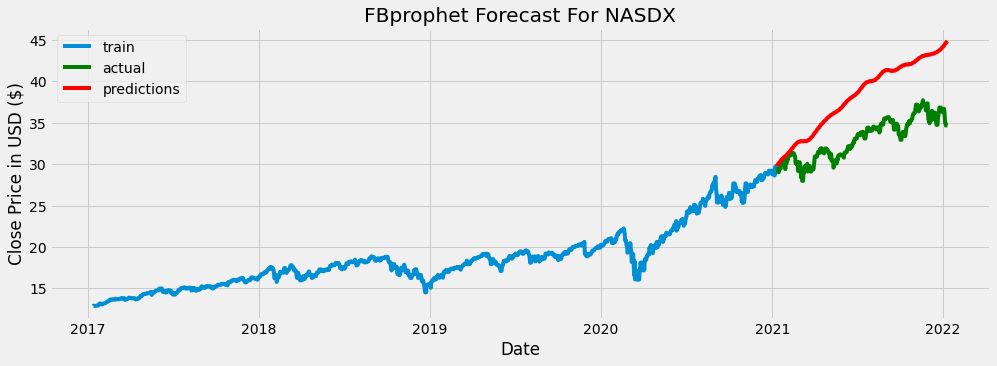

In [116]:
plt.figure(figsize=(15,5))
plt.title('FBprophet Forecast For NASDX')
plt.xlabel('Date')
plt.ylabel("Close Price in USD ($)")
plt.plot(train['y'],label="train")
plt.plot(test['y'],c='green',label='actual')
plt.plot(predictions['yhat'],c='red',label='predictions')
plt.legend()
plt.show()

In [117]:
rmses = pd.Series( [baseline_rmse, arima_rmse, lstm_rmse, fbprophet_rmse], index=['Baseline','ARIMA','LSTM','FBprophet'])
rmses = pd.DataFrame(rmses,columns=['RMSEs'])
rmses

,RMSEs
Baseline,1.588590
ARIMA,2.292706
LSTM,0.562183
FBprophet,5.670109


The LSTM model was the best model.

